<a href="https://colab.research.google.com/github/scottthomaswx/taf-verification/blob/main/TAF_Verification_Beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TAF Verification Plot Creation**

### **v2.00** - Scott Thomas (scott.r.thomas@noaa.gov)

### This program creates a plot showing forecast ceilings and visibility for a TAF Site (including PROB30s and TEMPO Groups) and compares it to observed ASOS Data.

### Data Availability
####January 1, 1996 to Present

##**Load Needed Packages**

###Click the play button below to install software to pull TAF and Observation Data, create the time range to pull the TAFs/Obs over, and create the plots. This should take 30-45 seconds.

In [278]:
# @title
%%capture
!pip install datetime
!pip install pytz
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install re
import pytz
import os
import sys
import requests
from datetime import timedelta
import datetime as datetime
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import re
!rm -rf sample_data/

##**Enter TAF Start Time (UTC) and Airport ID**

### Enter the 4 digit year, month, day, hour, and minute the TAF was issued (in UTC). Then click the play button to save your choice.

### Note: The TAF Issuance Time is NOT the same as the TAF Valid Time. Routine issuances are issued between 20-40 minutes before the TAF valid time. Amendments are valid immediately. You can find the issuance time by looking up the issuing WFO and UTC date it was issued on here. https://mesonet.agron.iastate.edu/wx/afos/list.phtml

In [330]:
year = '2024' #@param {type:"string"}
month = '05' #@param {type:"string"}
day = '07' #@param {type:"string"}
hour = '22' #@param {type:"string"}
minute = '16' #@param {type:"string"}
airport = 'KAZO' #@param {type:"string"}

timezone = 'UTC'
tz = pytz.timezone(timezone)
start = tz.localize(datetime(int(year),int(month),int(day),int(hour),int(minute)))

Extended_Taf_List = ['KAUS', 'KATL', 'KBDL', 'KBOS', 'KBWI', 'KBZN', 'KCLE', 'KCLT', 'KCVG', 'KDCA', 'KDEN', 'KDFW', 'KDTW', 'KEWR', 'KFLL', 'KIAD', 'KIAH', 'KIND',
                     'KJFK', 'KLAS', 'KLAX', 'KLGA', 'KMCO', 'KMDW', 'KMEM', 'KMIA', 'KMKE', 'KMSP', 'KMSY', 'KOAK', 'KONT', 'KORD', 'KPHL', 'KPHX', 'KPIT', 'KSAN',
                     'KSDF', 'KSEA', 'KSFO', 'KSLC', 'KSTL', 'KSWF', 'KSAT', 'KTPA', 'KTEB', 'PANC', 'PAFA', 'PGUM', 'PHNL']

if airport in Extended_Taf_List:
  end_time = start + timedelta(hours=31)
  end_year = end_time.strftime('%Y')
  end_month = end_time.strftime('%m')
  end_day = end_time.strftime('%d')
  end_hour = end_time.strftime('%H')
  end_minute = end_time.strftime('%M')
else:
  end_time = start + timedelta(hours=25)
  end_year = end_time.strftime('%Y')
  end_month = end_time.strftime('%m')
  end_day = end_time.strftime('%d')
  end_hour = end_time.strftime('%H')
  end_minute = end_time.strftime('%M')

start_time = start - timedelta(hours=1)
start_hour = start_time.strftime('%H')
start_day = start_time.strftime('%d')
start_month = start_time.strftime('%m')
start_year = start_time.strftime('%Y')
start_minute = start_time.strftime('%M')

##**Get Observations For TAF Period**

###Click the play button to pull the observations for your requested time window. If you encounter an error, ceiling and/or visibility data is unavailable for the time period you requested.

In [331]:
# @title
try:
  obs_url = f'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?&station={airport}&sts={start_year}-{start_month}-{start_day}T{start_hour}:00Z&ets={end_year}-{end_month}-{end_day}T{end_hour}:01Z&fmt=csv&data=vsby,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4'
  obs_df = pd.read_csv(obs_url, sep=",")

  obs_df['adj_visby'] = ""

  for v in range(len(obs_df['vsby'])):
    if obs_df.vsby[v] == 'M':
      obs_df.loc[v, 'adj_visby'] = np.nan
    elif float(obs_df.vsby[v]) > 6.0:
     obs_df.loc[v, 'adj_visby'] = 7.0
    else:
      obs_df.loc[v, 'adj_visby'] = obs_df.vsby[v]

  for c in range(len(obs_df['skyc1'])):
    if obs_df.skyc1[c] == 'BKN' or obs_df.skyc1[c] == 'OVC':
      obs_df.loc[c, 'adj_cigs'] = float(obs_df.skyl1[c])
    elif obs_df.skyc1[c] == 'CLR':
      obs_df.loc[c, 'adj_cigs'] = 7000
    elif obs_df.skyc1[c] == 'FEW' or obs_df.skyc1[c] == 'SCT':
      if obs_df.skyc2[c] == 'BKN' or obs_df.skyc2[c] == 'OVC':
        obs_df.loc[c, 'adj_cigs'] = float(obs_df.skyl2[c])
      elif obs_df.skyc2[c] != 'BKN' and obs_df.skyc2[c] != 'OVC':
        if obs_df.skyc3[c] == 'BKN' or obs_df.skyc3[c] == 'OVC':
          obs_df.loc[c, 'adj_cigs'] = float(obs_df.skyl3[c])
        elif obs_df.skyc3[c] != 'BKN' and obs_df.skyc3[c] != 'OVC':
          if obs_df.skyc4[c] == 'BKN' or obs_df.skyc4[c] == 'OVC':
            obs_df.loc[c, 'adj_cigs'] = float(obs_df.skyl4[c])
          else:
            obs_df.loc[c, 'adj_cigs'] = 7000
    elif obs_df.skyc1[c] == 'M':
      obs_df.loc[c, 'adj_cigs'] = np.nan

  for ch in range(len(obs_df.adj_cigs)):
    if isinstance(obs_df.adj_cigs[ch], float):
      if obs_df.adj_cigs[ch] > 7000:
        obs_df.loc[ch, 'adj_cigs'] = 7000

  for a in range(len(obs_df['valid'])):

    checktime =  datetime.strptime(obs_df['valid'][a], '%Y-%m-%d %H:%M')
    checktime = tz.localize(checktime)
    timediff = checktime - start
    timediff = timediff.total_seconds()
    hours = int(timediff // 3600)
    remaining_secs = timediff % 3600
    minutes = int(remaining_secs // 60) # Integer minutes
    count = hours + (minutes/60)
    obs_df.loc[a, "hour"] = count
    obs_df.loc[0,'hour'] = 0

except:
  warnings.warn('Observations Unavailable For The Requested Period')

##**Pull TAF**

###Click the play button to pull the TAF issued at the time you requested. If there is an error, it means no TAF is available at the time requested. This can occur when a TAF is issued after the synoptic hour due to a delay.

### **Data Source**
####Iowa State TAF Archive

In [332]:
# @title
try:
  taf_url = f'https://mesonet.agron.iastate.edu/cgi-bin/request/taf.py?station={airport}&ets={year}-{month}-{day}T{hour}:{int(minute)+1:02d}Z&sts={year}-{month}-{day}T{hour}:{int(minute)-1:02d}Z&fmt=csv&last=1'
  tafdf  = pd.read_csv(taf_url, sep=",")
  tafdf = tafdf

  for tafcigloop in range(len(tafdf['skyc'])):
    checkcig = tafdf.skyc[tafcigloop]
    checkcig_list = checkcig.split(',')
    checkcig_list = re.sub(r'[^a-zA-Z ]', '', checkcig).split()

    chgt = tafdf.skyl[tafcigloop]
    chgt_list = chgt.split(',')
    chgt_list = re.sub(r'[^0-9 ]', '', chgt).split()

    if checkcig_list[0] == 'BKN' or checkcig_list[0] == 'OVC':
        tafdf.loc[tafcigloop, 'cigs'] = float(chgt_list[0])
    elif checkcig_list[0] == 'SKC':
        tafdf.loc[tafcigloop, 'cigs'] = 7000
    elif checkcig_list[0] == 'FEW' or checkcig_list[0] == 'SCT':
        if checkcig_list[1] == 'BKN' or checkcig_list[1] == 'OVC':
          tafdf.loc[tafcigloop, 'cigs'] = float(chgt_list[1])
        else:
          tafdf.loc[tafcigloop, 'cigs'] = 7000

  for tafvisloop in range(len(tafdf['visibility'])):
    checkvis = tafdf.visibility[tafvisloop]
    if checkvis > 6.0:
      tafdf.loc[tafvisloop, 'visby'] = 7.0
    else:
      tafdf.loc[tafvisloop, 'visby'] = checkvis

  tafdf['adj_cigs'] = tafdf['cigs'].copy()

  for st in range(len(tafdf['fx_valid'])):
    groupstart = tafdf.fx_valid[st]
    checktime =  datetime.strptime(groupstart, '%Y-%m-%d %H:%M')
    checktime = tz.localize(checktime)
    timediff = checktime - start
    timediff = timediff.total_seconds()
    hours = int(timediff // 3600)
    remaining_secs = timediff % 3600
    minutes = int(remaining_secs // 60) # Integer minutes
    count = hours + (minutes/60)
    tafdf.loc[st, "starthour"] = count
    tafdf.loc[0,'starthour'] = 0

  for et in range(len(tafdf['fx_valid_end'])):
    groupend = tafdf.fx_valid_end[et]
    if isinstance(groupend, str):
      checktime =  datetime.strptime(groupend, '%Y-%m-%d %H:%M')
      checktime = tz.localize(checktime)
      timediff = checktime - start
      timediff = timediff.total_seconds()
      hours = int(timediff // 3600)
      remaining_secs = timediff % 3600
      minutes = int(remaining_secs // 60) # Integer minutes
      count = hours + (minutes/60)
      tafdf.loc[et, "endhour"] = count

  fmgroup = tafdf.query('ftype == "Observation" or ftype == "Forecast"')
  fmgroup = fmgroup.reset_index(drop=True)

  tmpo = tafdf.query('ftype == "Temporary"')
  tmpo = tmpo.reset_index(drop=True)

  pb30 = tafdf.query('ftype == "Probability"')
  pb30 = pb30.reset_index(drop=True)


  if airport in Extended_Taf_List:
      addlast = pd.DataFrame({'station': [(fmgroup.station.iloc[-1])], 'valid': [''], 'raw': [''], 'is_tempo': [False], 'sknt': [''], 'drct': [''], 'visibility': [fmgroup.visby.iloc[-1]], 'skyc': [fmgroup.skyc.iloc[-1]], 'skyl': [fmgroup.skyl.iloc[-1]], 'ws_level': [''],
                              'ftype': ['Forecast'], 'cigs': [fmgroup.cigs.iloc[-1]], 'visby': [fmgroup.visby.iloc[-1]],'starthour': ['30'], 'endhour': ['30'], 'adj_cigs': [fmgroup.adj_cigs.iloc[-1]]})
  elif airport not in Extended_Taf_List:
      addlast = pd.DataFrame({'station': [(fmgroup.station.iloc[-1])], 'valid': [''], 'raw': [''], 'is_tempo': [False], 'sknt': [''], 'drct': [''], 'visibility': [fmgroup.visby.iloc[-1]], 'skyc': [fmgroup.skyc.iloc[-1]], 'skyl': [fmgroup.skyl.iloc[-1]], 'ws_level': [''],
                              'ftype': ['Forecast'], 'cigs': [fmgroup.cigs.iloc[-1]], 'visby': [fmgroup.visby.iloc[-1]],'starthour': ['24'], 'endhour': ['24'], 'adj_cigs': [fmgroup.adj_cigs.iloc[-1]]})

  fmgroup = pd.concat([fmgroup, addlast], ignore_index=True)

except:
  warnings.warn('TAF Unavailable For The Requested Period')

/tmp/ipython-input-643733992.py:81: UserWarning: TAF Unavailable For The Requested Period
  warnings.warn('TAF Unavailable For The Requested Period')


##**Plot Data**

### Click the play button to create the plot of Ceiling and Visibility Data. The image will save in the folder to the left.

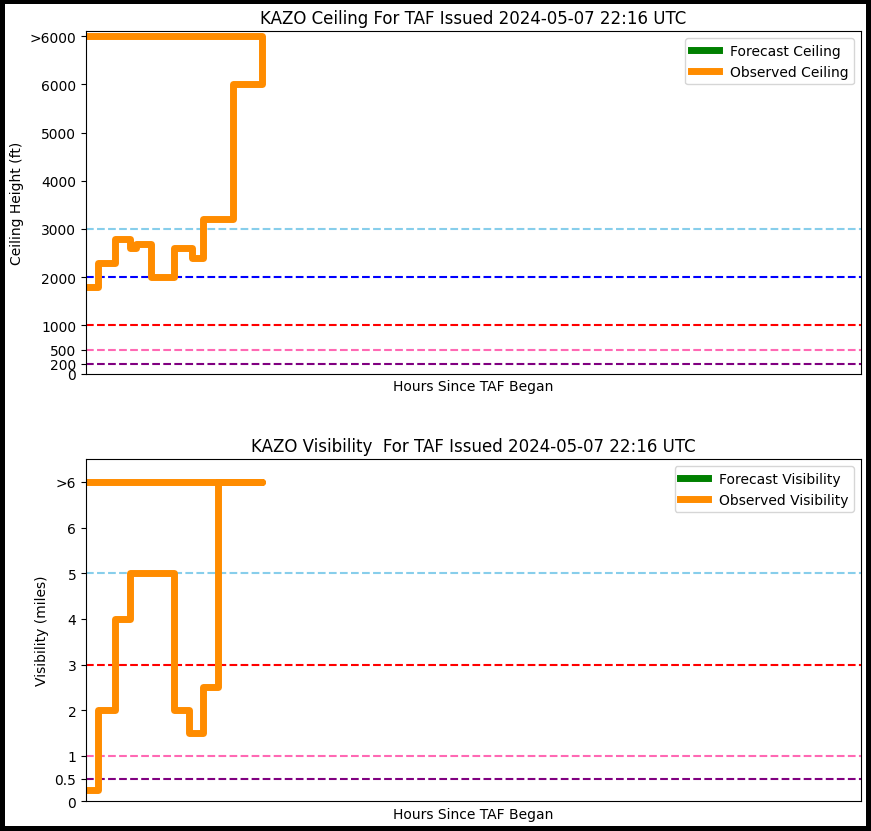

In [333]:
# @title
fig = plt.figure(figsize=(10, 10), facecolor='white', edgecolor="black", linewidth =6)

ax1 = plt.subplot(2,1,1)
ax1.set_title(f'{airport} Ceiling For TAF Issued {year}-{month}-{day} {hour}:{minute} UTC')
ax1.axhline(y=3000, color='skyblue', linestyle='--')
ax1.axhline(y=2000, color='blue', linestyle='--')
ax1.axhline(y=1000, color='red', linestyle='--')
ax1.axhline(y=500, color='hotpink', linestyle='--')
ax1.axhline(y=200, color='purple', linestyle='--')

fcstcig = ax1.step(fmgroup['starthour'], fmgroup['cigs'], color = 'green', label = 'Forecast Ceiling', linewidth = 5, zorder = 1)
cigline = ax1.step(obs_df['hour'], obs_df['adj_cigs'], color = 'darkorange', label = 'Observed Ceiling', linewidth = 5, zorder=  2)


for tm in range(len(tmpo['cigs'])):
  if not np.isnan(tmpo.cigs[tm]):
    ax1.scatter(tmpo.starthour[tm], tmpo.cigs[tm], color = 'black', marker = '^', zorder = 3, s = 100)
    ax1.scatter(tmpo.endhour[tm], tmpo.cigs[tm], color = 'black', marker = '^', zorder = 3, s = 100)
    x_coords = [tmpo.starthour[tm], tmpo.endhour[tm]]
    y_coords = [tmpo.cigs[tm], tmpo.cigs[tm]]
    ax1.plot(x_coords, y_coords, color = 'black', linewidth = 2, label = 'TEMPO', zorder = 3)
for pr in range(len(pb30['cigs'])):
  if not np.isnan(pb30.cigs[pr]):
    ax1.scatter(pb30.starthour[pr], pb30.cigs[pr], color = 'maroon', marker = '^', zorder = 3, s = 100)
    ax1.scatter(pb30.endhour[pr], pb30.cigs[pr], color = 'maroon', marker = '^', zorder = 3, s = 100)
    x_coords = [pb30.starthour[pr], pb30.endhour[pr]]
    y_coords = [pb30.cigs[pr], pb30.cigs[pr]]
    ax1.plot(x_coords, y_coords, color = 'maroon', linewidth = 2, label = 'PROB30', zorder = 3)

ax1.set_ylim(0,7100)
ax1.set_ylabel('Ceiling Height (ft)')

ax1.set_yticks([0,200, 500,1000,2000,3000,4000,5000,6000,7000])
ax1.set_yticklabels(['0','200','500', '1000', '2000', '3000', '4000', '5000', '6000', '>6000'])

ax1.set_xlabel('Hours Since TAF Began')
ax1.legend(loc = 'upper right')

if re.search('-AA', tafdf.product_id[0]) or re.search('-CC', tafdf.product_id[0]) or  re.search('-RR', tafdf.product_id[0]):
  taf_start_box = datetime.strptime(tafdf.valid[0], '%Y-%m-%d %H:%M')
  taf_start_hour = int(taf_start_box.strftime('%H'))
  if taf_start_hour >= 0 and taf_start_hour < 6:
    taf_end_hour = 24
  if taf_start_hour >= 6 and taf_start_hour < 12:
    taf_end_hour = 6
  if taf_start_hour >= 12 and taf_start_hour < 18:
    taf_end_hour = 12
  if taf_start_hour >= 18 and taf_start_hour < 24:
    taf_end_hour = 18

  hours_left = taf_end_hour - taf_start_hour
  if airport in Extended_Taf_List:
    hours_left +=6
  ax1.set_xlim(-0.1,(hours_left-0.5))
  ax1.set_xticks(np.arange(0,(hours_left-0.5),1))

else:
  if airport in Extended_Taf_List:
    ax1.set_xlim(-0.1,29.5)
    ax1.set_xticks(np.arange(0,29.5,1))
  elif airport not in Extended_Taf_List:
    ax1.set_xlim(-0.1,23.5)
    ax1.set_xticks(np.arange(0,23.5,1))

ax2 = plt.subplot(2,1,2)
ax2.set_title(f'{airport} Visibility  For TAF Issued {year}-{month}-{day} {hour}:{minute} UTC')
ax2.axhline(y=5, color='skyblue', linestyle='--')
ax2.axhline(y=3, color='red', linestyle='--')
ax2.axhline(y=1, color='hotpink', linestyle='--')
ax2.axhline(y=0.5, color='purple', linestyle='--')

fcstvis = ax2.step(fmgroup['starthour'], fmgroup['visby'], color = 'green', label = 'Forecast Visibility', linewidth = 5, zorder = 1)
visline = ax2.step(obs_df['hour'], obs_df['adj_visby'], color = 'darkorange', label = 'Observed Visibility', linewidth = 5, zorder = 2)

for te in range(len(tmpo['visby'])):
  if not np.isnan(tmpo.visby[te]):
    ax2.scatter(tmpo.starthour[te], tmpo.visby[te], color = 'black', marker = '^', zorder = 3, s = 100)
    ax2.scatter(tmpo.endhour[te], tmpo.visby[te], color = 'black', marker = '^', zorder = 3, s = 100)
    x_coords = [tmpo.starthour[te], tmpo.endhour[te]]
    y_coords = [tmpo.visby[te], tmpo.visby[te]]
    ax2.plot(x_coords, y_coords, color = 'black', linewidth = 2, label = 'TEMPO', zorder = 3)
for po in range(len(pb30['visby'])):
  if not np.isnan(pb30.visby[po]):
    ax2.scatter(pb30.starthour[po], pb30.visby[po], color = 'maroon', marker = '^', zorder = 3, s = 100)
    ax2.scatter(pb30.endhour[po], pb30.visby[po], color = 'maroon', marker = '^', zorder = 3, s = 100)
    x_coords = [pb30.starthour[po], pb30.endhour[po]]
    y_coords = [pb30.visby[po], pb30.visby[po]]
    ax2.plot(x_coords, y_coords, color = 'maroon', linewidth = 2, label = 'PROB30', zorder = 3)

ax2.legend(loc = 'upper right')
ax2.set_xlabel('Hours Since TAF Began')
ax2.set_ylabel('Visibility (miles)')
ax2.set_ylim(0,7.5)
ax2.set_yticks([0,0.5,1,2,3,4,5,6,7])
ax2.set_yticklabels(['0','0.5','1','2','3','4','5','6','>6'])

if re.search('-AA', tafdf.product_id[0]) or re.search('-CC', tafdf.product_id[0]) or  re.search('-RR', tafdf.product_id[0]):
  taf_start_box = datetime.strptime(tafdf.valid[0], '%Y-%m-%d %H:%M')
  taf_start_hour = int(taf_start_box.strftime('%H'))
  if taf_start_hour >= 0 and taf_start_hour < 6:
    taf_end_hour = 24
  if taf_start_hour >= 6 and taf_start_hour < 12:
    taf_end_hour = 6
  if taf_start_hour >= 12 and taf_start_hour < 18:
    taf_end_hour = 12
  if taf_start_hour >= 18 and taf_start_hour < 24:
    taf_end_hour = 18

  hours_left = taf_end_hour - taf_start_hour
  if airport in Extended_Taf_List:
    hours_left +=6
  ax2.set_xlim(-0.1,(hours_left-0.5))
  ax2.set_xticks(np.arange(0,(hours_left-0.5),1))

else:
  if airport in Extended_Taf_List:
    ax2.set_xlim(-0.1,29.5)
    ax2.set_xticks(np.arange(0,29.5,1))
  elif airport not in Extended_Taf_List:
    ax2.set_xlim(-0.1,23.5)
    ax2.set_xticks(np.arange(0,23.5,1))


plt.subplots_adjust(hspace=0.25)
plt.savefig(f'TAFVerification_{airport}_{year}{month}{day}{hour}.png', bbox_inches = 'tight')

## **Zip All Files For Download**

### Zips all .png files to make downloading multiple files easier

In [ ]:
!zip -r /content/TAF_Verif.zip /content/*.png

## **Remove All Files In Folder To Left**

### Removes all ZIP and PNG files in content folder to left. Useful if you have made a large number of plots.

In [ ]:
!rm /content/*.png
!rm /content/*.zip

rm: cannot remove '/content/*.zip': No such file or directory
